# Looking at and random sampling from the 10D-encoded latent space.

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import uniform, choice
import absl.logging
import os
absl.logging.set_verbosity(absl.logging.ERROR)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from keras import models

### ~~Representations during training for each digit.~~
I have no idea how to visualize 10-dimensional blobs morphing over time. Hit me up if you have ideas.

### Final mapping regions for each digit
It is clear from the plots that the representations have specialized quite a bit, which is unfortunate.

In [41]:
ptarr = np.load("saves/10d_points.npy", allow_pickle=True)

In [42]:
train_df = pd.read_csv("mnist/mnist_train.csv", header=None)
train_x = np.array(train_df.iloc[:, 1:].to_numpy().reshape((-1, 28, 28, 1)))
train_x = train_x/255.
train_y = np.array(train_df.iloc[:, 0].to_numpy().reshape((-1, 1)))

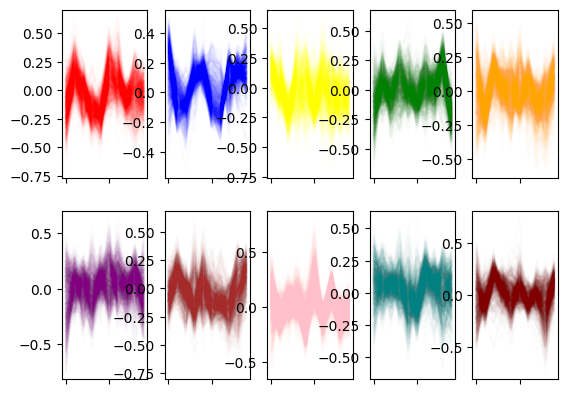

In [43]:
encoder10d = models.load_model("saved_models/encoder_10d", compile=False)

_, ax = plt.subplots(2, 5)
colors = ["red", "blue", "yellow", "green", "orange", "purple", "brown", "pink", "teal", "maroon"]
preds = {}
ranges = {}
for dig in range(10):
    i, j = (dig - dig % 5) // 5, dig % 5

    dig_samp_xs, dig_samp_ys = [], []
    for _ in range(1000):
        ind = choice(range(len(train_x)))
        while train_y[ind].item() != dig:
            ind = choice(range(len(train_x)))

        dig_samp_xs.append(train_x[ind])
        dig_samp_ys.append(train_y[ind])

    dig_samp_xs = np.array(dig_samp_xs).reshape((-1, 28, 28, 1))
    dig_pred_ys = encoder10d.predict(dig_samp_xs, verbose=0)
    preds[dig] = dig_pred_ys

    for k in range(10):
        nodeputs = dig_pred_ys[:, k]
        ranges[k] = [np.mean(nodeputs) - 1.2 * np.std(nodeputs), np.mean(nodeputs) + 1.2 * np.std(nodeputs)]
    for pred in dig_pred_ys:
        ax[i, j].plot(range(10), pred, color=colors[dig], alpha=0.01)
    ax[i, j].set_xticklabels([])
plt.show()

### All final mappings on the same plot to get a sense of differentiation in class representations.
While this is somewhat less useful than before, it kindof drives home the fact that for each axis of this space, there is quite a lot of non-overlap in the representation regions. They have deviated well away from sphere-ish (hypersphere-ish) region near the origin.

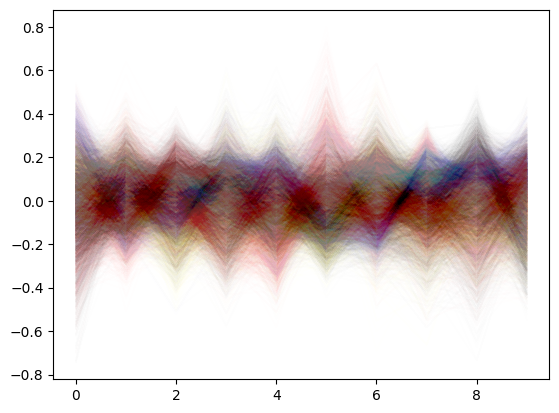

In [44]:
for dig in range(10):
    for pred in preds[dig]:
        plt.plot(range(10), pred, color=colors[dig], alpha=0.005)
plt.show()

### Random sampling by class
As seen above, the representations are highly interdependent now, meaning the conditioning label is less decisive. Sampling near 0 is useless now but let's still try.

#### 1. Sampling near 0

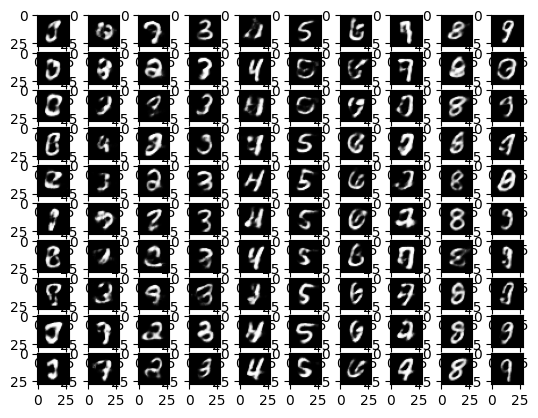

In [45]:
decoder10d = models.load_model("saved_models/decoder_10d", compile=False)

r = 0.15
_, ax2 = plt.subplots(10, 10)
for i in range(10):
    for j in range(10):
        hotcode = [0] * 10
        hotcode[j] = 1
        sample = np.array([[*[uniform(-r, r) for _ in range(10)], *hotcode]])
        pred = decoder10d.predict(sample, verbose=0)[0]
        ax2[i, j].imshow(pred, cmap="gray")
plt.show()

#### 2. Sampling from known ranges  
Clearly this is still not enough to guarantee meaningful outputs unfortunately. Some of the intended classes are bleeding over into others. The conditioning signal has lost its power.
While there might be a better way than to take values blindly from within 1.2 standard deviations of the respective means, it's more effort than it's worth. 3 or 4d is good enough to get a good variety of outputs without losing condition strength for this dataset. 

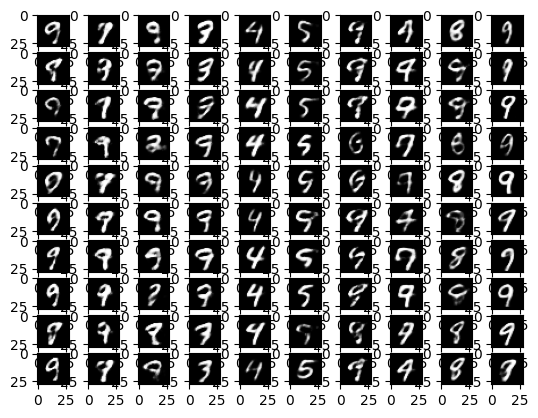

In [46]:
_, ax3 = plt.subplots(10, 10)
for i in range(10):
    for j in range(10):
        hotcode = [0] * 10
        hotcode[j] = 1
        sample = np.array([[*[uniform(*ranges[k]) for k in range(10)], *hotcode]])
        pred = decoder10d.predict(sample, verbose=0)[0]
        ax3[i, j].imshow(pred, cmap="gray")
plt.show()

## These outputs are terrible. Let's look at the batchnormed model instead.
One thing to note is that batchnormalization while it has a regularizing effect also makes the model fit less well to the data. Training loss bottoms out at a higher point compared to the same architecture without batchnorm.

### Final mapping regions for each digit
There is a lot less interdependence in the axes here and the regions stick well to the origin and for all digits except 1, the zero region is well populated on all axes.

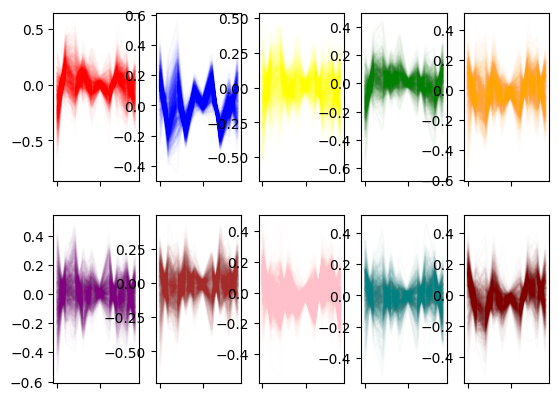

In [47]:
encoder10d_batchnorm = models.load_model("saved_models/encoder_10d_batchnorm", compile=False)

_, ax = plt.subplots(2, 5)
colors = ["red", "blue", "yellow", "green", "orange", "purple", "brown", "pink", "teal", "maroon"]
preds = {}
for dig in range(10):
    i, j = (dig - dig % 5) // 5, dig % 5

    dig_samp_xs, dig_samp_ys = [], []
    for _ in range(1000):
        ind = choice(range(len(train_x)))
        while train_y[ind].item() != dig:
            ind = choice(range(len(train_x)))

        dig_samp_xs.append(train_x[ind])
        dig_samp_ys.append(train_y[ind])

    dig_samp_xs = np.array(dig_samp_xs).reshape((-1, 28, 28, 1))
    dig_pred_ys = encoder10d_batchnorm.predict(dig_samp_xs, verbose=0)
    preds[dig] = dig_pred_ys

    for pred in dig_pred_ys:
        ax[i, j].plot(range(10), pred, color=colors[dig], alpha=0.01)
    ax[i, j].set_xticklabels([])
plt.show()

### All final mappings on the same plot to get a sense of differentiation in class representations.
Clearly the mappings are a lot less specified to specific ranges in their axes, although their ranges are not of the same size.

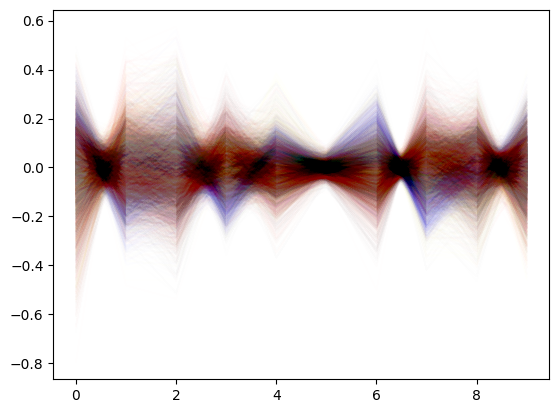

In [48]:
for dig in range(10):
    for pred in preds[dig]:
        plt.plot(range(10), pred, color=colors[dig], alpha=0.005)
plt.show()

### Random sampling by class
Here, sampling near origin seems to work well enough! The 1s are misbehaved as always. Also notice the relatively low variability in generation even given the high dimensionality. This is to be expected given the batchnorm. As mentioned before, it here is a tradeoff between accuracy and generality.

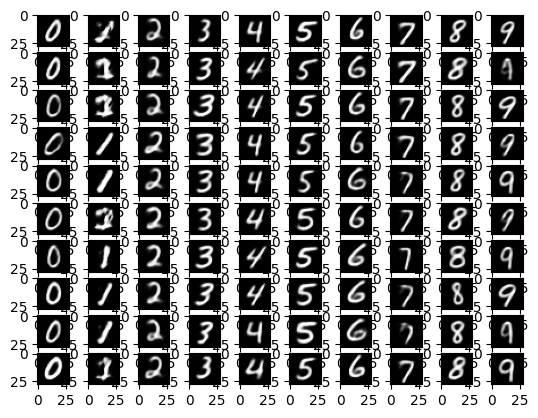

In [50]:
decoder10d_batchnorm = models.load_model("saved_models/decoder_10d_batchnorm", compile=False)

r = 0.25
_, ax2 = plt.subplots(10, 10)
for i in range(10):
    for j in range(10):
        hotcode = [0] * 10
        hotcode[j] = 1
        sample = np.array([[*[uniform(-r, r) for _ in range(10)], *hotcode]])
        pred = decoder10d_batchnorm.predict(sample, verbose=0)[0]
        ax2[i, j].imshow(pred, cmap="gray")
plt.show()

### In conclusion,
Higher-dimensional spaces are hard to deal with not only because it's easier for the class regions to wiggle around, but also because even if we do a good job of chaining them down at the origin we still need exponentially more data to meaningfully populate the space. For a dataset as simple as handwritten digits, this is both redundant and difficult.

While batch-normalizing the encoder's outputs helps a great deal, the tradeoff is less-sharp autoencoding (and generations). While great for sampling easily it also doesn't address the difficulty of densely packing the space.

Overall I'm happy with this project, although I have a feeling there are glaring errors lurking everywhere I'll get called out for. In my defense most of the work went in during endterms week which I now dearly regret.